In [14]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
from xgboost.sklearn import XGBClassifier

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
df = pd.read_csv('../csvs/short_integration_features.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr_short']
#Nrows = df.shape[0]
#print Nrows, len(np.where(df['Stable']==0)[0])
print df.shape
df.head()

(14999, 116)


,runstring,Stable,Rel_Eerr,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0000000.bin,0.0,1.099985e-04,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0000001.bin,0.0,1.388587e-08,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0000002.bin,0.0,3.048261e-04,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,0000003.bin,1.0,6.492574e-10,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0000004.bin,0.0,9.336734e-07,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [7]:
print df.columns.values

['runstring' 'Stable' 'Rel_Eerr' 't_final_short' 'avg_a1' 'std_a1' 'max_a1'
 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' 'max_eH2' 'min_eH2' 'avg_iH2'
 'std_iH2' 'max_iH2' 'min_iH2' 'avg_ecross2'

In [66]:
#"['daOverRH1' 'daOverRH2' 'mindaOverRH' 'maxdaOverRH' 'norm_LyapunovTime']"
features = []
features += ['avg_iH1', 'avg_iH2']
#features += ['mindaOverRH', 'maxdaOverRH']
#features += ['daOvera1', 'daOvera2']
#features += ['mindaOvera', 'maxdaOvera']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
#features += ['norm_std_e1', 'norm_max_e1', 'norm_std_window10_e1', 'norm_max_window10_e1']
#features += ['norm_std_e2', 'norm_max_e2', 'norm_std_window10_e2', 'norm_max_window10_e2']
#features += ['norm_std_e3', 'norm_max_e3', 'norm_std_window10_e3', 'norm_max_window10_e3']
#features += ['avg_eH1', 'std_eH1', 'max_eH1', 'min_eH1']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
#features += ['avg_eH2', 'std_eH2', 'max_eH2', 'min_eH2']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
#features += ['avg_eH3', 'std_eH3', 'max_eH3', 'min_eH3']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
#features += ['norm_std_inc1', 'norm_max_inc1', 'norm_std_window10_inc1', 'norm_max_window10_inc1']
#features += ['norm_std_inc2', 'norm_max_inc2', 'norm_std_window10_inc2', 'norm_max_window10_inc2']
#features += ['norm_std_inc3', 'norm_max_inc3', 'norm_std_window10_inc3', 'norm_max_window10_inc3']
#features += ['std_iH1', 'max_iH1', 'min_iH1']
#features += ['std_iH2', 'max_iH2', 'min_iH2']
#features += ['std_iH3', 'max_iH3', 'min_iH3']
#features += ['mean_std_iH']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['Lyapunov_time']

y = df['Stable']
X = df[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,max_ecross2,min_ecross2,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a1_slope,norm_a2_slope,norm_a3_slope,Lyapunov_time
0,0.396282,0.481704,0.000329,0.001083,0.000214,0.000456,0.000701,0.001978,0.000446,0.000964,...,0.333921,0.077775,0.297364,0.016641,0.339655,0.010871,-9.963524e-11,2.144832e-10,2.681898e-11,9041.175397
1,1.034575,0.823935,0.000739,0.002137,0.000202,0.000463,0.000200,0.000350,0.000226,0.000377,...,0.307149,0.075092,0.115674,0.039718,0.251880,0.137917,-4.938423e-11,3.559377e-11,-9.314702e-11,2192.382019
2,0.440470,0.491261,0.001951,0.003550,0.001735,0.002860,0.002303,0.004034,0.002080,0.003409,...,0.583040,0.328325,0.038930,0.002380,0.026117,0.007227,6.451005e-11,-3.330088e-11,-4.095504e-11,2191.525922
3,0.432098,0.550624,0.000026,0.000120,0.000005,0.000009,0.000019,0.000050,0.000016,0.000041,...,0.048402,0.000124,0.514386,0.003658,0.301072,0.279903,8.676076e-12,7.816527e-13,-7.257099e-12,58599.215966
4,5.722053,17.442426,0.028284,0.063028,0.004313,0.010716,0.038832,0.160685,0.090892,0.112168,...,9.321252,0.823132,0.496372,0.248052,1.358604,0.261358,6.816926e-08,3.913858e-08,-2.610208e-08,43524.152375


In [12]:
def pr_auc(y_pred, y_true):
    print(y_pred)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return 'pr_auc', auc(recall, precision, reorder=True)

First see how the model with the previous found optimal parameters performs with this data, despite being fed slightly different parameters

In [15]:
model = XGBClassifier(seed = 3, learning_rate = 0.01, subsample = 0.9, n_estimators=225, colsample_bytree=0.75, max_depth=9, min_child_weight=4)
#from sklearn.model_selection import train_test_split

In [52]:
Nrows = int(0.4*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]

In [30]:
model.fit(trainX, trainY)
preds_prob = model.predict_proba(testX)[:, 1]
preds = model.predict(testX)

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
pr_auc(preds, testY)

[ 0.  0.  0. ...,  0.  1.  0.]


('pr_auc', 0.91092362955271733)


Model Report
Accuracy : 0.9134


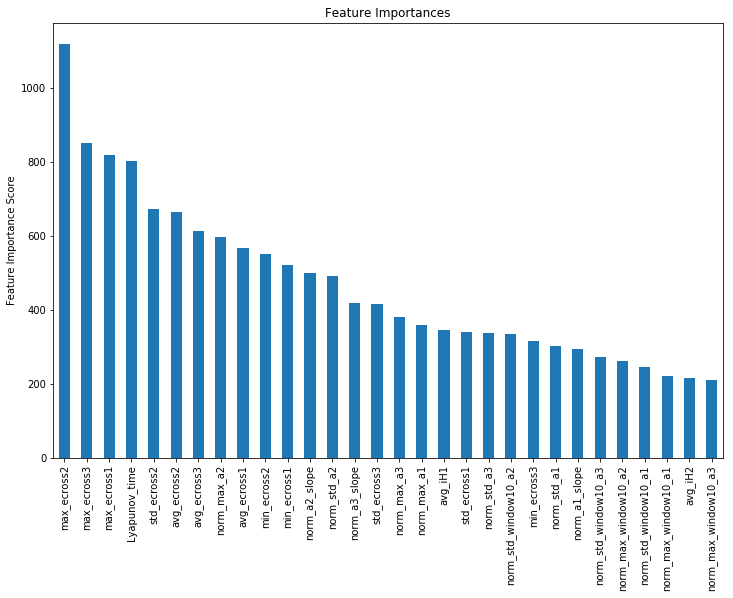

In [47]:
# feature importances
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')

#drop out the five weakest ones, prehaps try substituting
#it with another set of 5 features, and see if it improves its score
#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(testY, preds)

In [28]:
def plot_proba_hist(pred_prob, testY, ylim = 900):
    # Histogram:

    bins = 50
    Stable=pred_prob[np.where(testY==1)]
    print Stable[:5][:]
    Unstable=pred_prob[np.where(testY==0)]
    print Stable.size, Unstable.size

    fig, ax1 = plt.subplots()
    ax1.hist([Unstable, Stable], bins, alpha=0.5, label='No', color=['blue', 'green'], linewidth = 1, edgecolor='black', histtype='barstacked')
    #ax1.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
    print Stable.size
    ax1.set_xlabel('Predicted Probability', fontsize=14)
    ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
    for tl in ax1.get_yticklabels():
        tl.set_color('blue')


    ax2 = ax1.twinx()
    #ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
    ax2.set_ylabel('Stable', fontsize=14, color='green')
    for tl in ax2.get_yticklabels():
        tl.set_color('green')

    #ax1.set_ylim(ax2.get_ylim())
    ax1.set_ylim([0,ylim])
    ax2.set_ylim([0,ylim])

[ 0.93488199  0.94303113  0.49780986  0.89563441  0.94334334]
3531 5469
3531


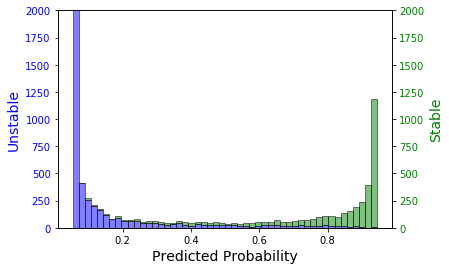

In [29]:
plot_proba_hist(preds_prob, testY, ylim=2000)

In [49]:
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
print feat_imp.index
vals = feat_imp.index[-5:]
print vals

Index([u'max_ecross2', u'max_ecross3', u'max_ecross1', u'Lyapunov_time',
       u'std_ecross2', u'avg_ecross2', u'avg_ecross3', u'norm_max_a2',
       u'avg_ecross1', u'min_ecross2', u'min_ecross1', u'norm_a2_slope',
       u'norm_std_a2', u'norm_a3_slope', u'std_ecross3', u'norm_max_a3',
       u'norm_max_a1', u'avg_iH1', u'std_ecross1', u'norm_std_a3',
       u'norm_std_window10_a2', u'min_ecross3', u'norm_std_a1',
       u'norm_a1_slope', u'norm_std_window10_a3', u'norm_max_window10_a2',
       u'norm_std_window10_a1', u'norm_max_window10_a1', u'avg_iH2',
       u'norm_max_window10_a3'],
      dtype='object')
Index([u'norm_max_window10_a2', u'norm_std_window10_a1',
       u'norm_max_window10_a1', u'avg_iH2', u'norm_max_window10_a3'],
      dtype='object')


In [75]:
print trainX.shape, testX.shape
trainX2 = trainX.drop(vals, 1)
testX2 = testX.drop(vals, 1)
print trainX2.shape
features2 = features[:]
print len(features2)
features2 += ['avg_eH1', 'std_eH1', 'max_eH1', 'min_eH1']
print len(features2)
new_features2 = [e for e in features2 if e not in vals]
print len(new_features2)

(5999, 30) (9000, 30)
(5999, 25)
30
34
29


In [76]:
model.fit(trainX, trainY)
preds_prob = model.predict_proba(testX)[:, 1]
preds = model.predict(testX)

pr_auc(preds, testY)

[ 0.  0.  0. ...,  0.  1.  0.]


('pr_auc', 0.91092362955271733)

Try reoptimizing the parameters, run a large grid search

In [77]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import ipywidgets as widgets
from ipywidgets import FloatSlider, fixed
from ipywidgets.widgets.widget_selection import SelectionSlider

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


This is running the model with the previous grid search from the first dataset

In [79]:
model3 = XGBClassifier(seed = 3, learning_rate = 0.01, subsample = 0.9)
n_estimators = [175,200,225]
max_depth = [6,7,8,9]
cols_by_tree = np.linspace(0.7,0.9, 5)
min_c_w = np.linspace(3,8,6)
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_child_weight = min_c_w, colsample_bytree=cols_by_tree)
grid = GridSearchCV(estimator = model3, param_grid = param_grid, scoring='average_precision',iid=False,cv=5, verbose = 85)
grid.fit(X, y) #total dataset

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0, score=0.961683 -   2.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0, score=0.962538 -   1.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0, score=0.961536 -   1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, mi

[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0, score=0.962385 -   1.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   41.5s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0, score=0.961673 -   1.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   42.5s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0, score=0.965934 -   1.1s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   43.6s remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=5.0, score=0.963409 -   1.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   44.7s remaining:    0.0s
[CV] n_estimators=20

[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0, score=0.961683 -   1.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:  1.4min remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0, score=0.965924 -   1.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  1.4min remaining:    0.0s
[CV] n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0 
[CV]  n_estimators=175, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0, score=0.963302 -   1.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.4min remaining:    0.0s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=6, min_child_weight=7.0, score=0.962352 -   1.2s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:  1.4min remaining:    0.0s
[CV] n_estimators=20

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0, score=0.963334 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0, score=0.967014 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0, score=0.964080 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0, score=0.964221 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0, score=0.964498 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0, score=0.963200 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0, score=0.966565 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0, score=0.964118 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0, score=0.963869 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0, score=0.964342 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=7, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0, score=0.964015 -   1.8s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0, score=0.967178 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0, score=0.964387 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0, score=0.965162 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0, score=0.964636 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0, score=0.963909 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0, score=0.966628 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0, score=0.964610 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0, score=0.964654 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0, score=0.965105 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=8, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0, score=0.964368 -   1.9s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0, score=0.967270 -   1.9s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0, score=0.964521 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0, score=0.965445 -   2.1s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0, score=0.964637 -   2.0s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0, score=0.964249 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0, score=0.966856 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0, score=0.964472 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0, score=0.964858 -   2.4s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0, score=0.965177 -   1.9s
[CV] n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0, score=0.961862 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0, score=0.966438 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0, score=0.963266 -   1.2s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0, score=0.962817 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0, score=0.963171 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=6, min_c

[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0, score=0.962760 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0, score=0.961969 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0, score=0.966335 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0, score=0.963095 -   1.2s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0, score=0.962754 -   1.3s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=6, min_c

[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0, score=0.963673 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0, score=0.964215 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0, score=0.963016 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0, score=0.966874 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0, score=0.963800 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.75, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=7, min_c

[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0, score=0.963271 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0, score=0.963401 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0, score=0.963859 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0, score=0.963026 -   1.9s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0, score=0.966499 -   4.2s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=7, min_c

[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0, score=0.966582 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0, score=0.963771 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0, score=0.964919 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0, score=0.964302 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0, score=0.963782 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_c

[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0, score=0.963315 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0, score=0.966165 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0, score=0.963669 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0, score=0.964148 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0, score=0.964280 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=8, min_c

[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0, score=0.964083 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0, score=0.963161 -   1.7s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0, score=0.966414 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0, score=0.964110 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0, score=0.964891 -   3.1s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=9, min_c

[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0, score=0.964178 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0, score=0.964029 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0, score=0.963250 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0, score=0.966305 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0, score=0.963417 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.75, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=200, colsample_bytree=0.75, max_depth=9, min_c

[CV]  n_estimators=225, colsample_bytree=0.75, max_depth=9, min_child_weight=8.0, score=0.964273 -   1.8s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0, score=0.961429 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0, score=0.961897 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0, score=0.961765 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0, score=0.966109 -   1.2s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weigh

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=6, min_child_weight=5.0, score=0.963512 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0, score=0.961557 -   1.0s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0, score=0.961940 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0, score=0.961512 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0, score=0.965815 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=6, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=6, min_child_weight=8.0, score=0.963383 -   1.9s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0, score=0.962946 -   4.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0, score=0.963357 -   1.3s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0, score=0.962766 -   1.3s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0, score=0.966358 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=7, min_child_weight=5.0, score=0.963712 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0, score=0.962768 -   1.3s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0, score=0.963215 -   1.2s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0, score=0.962592 -   1.2s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0, score=0.966356 -   1.2s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=7, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=7, min_child_weight=8.0, score=0.963690 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0, score=0.963808 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0, score=0.963919 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0, score=0.962872 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0, score=0.966703 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=8, min_child_weight=5.0, score=0.964039 -   1.8s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0, score=0.963554 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0, score=0.963803 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0, score=0.963133 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0, score=0.966461 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=8, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=8, min_child_weight=8.0, score=0.963807 -   1.7s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0, score=0.964435 -   1.7s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0, score=0.964441 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0, score=0.963482 -   1.7s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0, score=0.966596 -   1.7s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=9, min_child_weight=5.0, score=0.964415 -   2.0s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0, score=0.963798 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0, score=0.963717 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0, score=0.963122 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0, score=0.966090 -   1.5s
[CV] n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.8, max_depth=9, min_child_weight

[CV]  n_estimators=225, colsample_bytree=0.8, max_depth=9, min_child_weight=8.0, score=0.964203 -   1.8s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0, score=0.961148 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0, score=0.962098 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0, score=0.961569 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0, score=0.966181 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_ch

[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=5.0, score=0.966776 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=5.0, score=0.962913 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0, score=0.961329 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0, score=0.962068 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0, score=0.961453 -   1.1s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=6, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=6, min_c

[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=8.0, score=0.962394 -   1.3s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=8.0, score=0.966484 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=6, min_child_weight=8.0, score=0.962968 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=3.0, score=0.962990 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=3.0, score=0.963550 -   1.4s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=7, min_c

[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0, score=0.964329 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0, score=0.963125 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0, score=0.967297 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=5.0, score=0.963570 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=6.0, score=0.962657 -   1.2s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=7, min_child_weight=6.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=7, min_c

[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0, score=0.963504 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0, score=0.964264 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0, score=0.963103 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0, score=0.966944 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=7, min_child_weight=8.0, score=0.963590 -   1.6s
[CV] n_estimators=175, colsample_bytree=0.85, max_depth=8, min_child_weight=3.0 
[CV]  n_estimators=175, colsample_bytree=0.85, max_depth=8, min_c

[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0, score=0.963917 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0, score=0.964785 -   1.9s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0, score=0.964526 -   1.9s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0, score=0.963620 -   2.0s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0, score=0.967263 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_c

[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0, score=0.966594 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0, score=0.963689 -   1.6s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0, score=0.964111 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0, score=0.964667 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0, score=0.963586 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=8, min_c

[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0, score=0.963766 -   1.8s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0, score=0.966879 -   1.8s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0, score=0.963828 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0, score=0.964833 -   2.0s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0, score=0.964640 -   4.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=9, min_c

[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0, score=0.964303 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0, score=0.963054 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0, score=0.966345 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0, score=0.963817 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0, score=0.964292 -   5.4s
[CV] n_estimators=225, colsample_bytree=0.85, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.85, max_depth=9, min_c

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0, score=0.962384 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0, score=0.961961 -   1.3s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0, score=0.966393 -   4.8s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0, score=0.962433 -   1.2s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0, score=0.962093 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0, score=0.962320 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0, score=0.961898 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0, score=0.966070 -   1.2s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0, score=0.962163 -   1.2s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0, score=0.962294 -   1.3s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=6, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0, score=0.963668 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0, score=0.962627 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0, score=0.966653 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0, score=0.963116 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0, score=0.963553 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0, score=0.963621 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0, score=0.962612 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0, score=0.966649 -   1.4s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0, score=0.963034 -   1.4s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0, score=0.963165 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=7, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0, score=0.963912 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0, score=0.963253 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0, score=0.966654 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0, score=0.963538 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0, score=0.964365 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0, score=0.963976 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0, score=0.962670 -   1.6s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0, score=0.966546 -   1.5s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0, score=0.963613 -   1.5s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0, score=0.963629 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=8, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0, score=0.964158 -   1.8s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0, score=0.963193 -   1.8s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0, score=0.966776 -   1.9s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0, score=0.963780 -   1.8s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0, score=0.964816 -   2.0s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=5.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight

[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0, score=0.964200 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0, score=0.963111 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0, score=0.966622 -   1.7s
[CV] n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=200, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0, score=0.963706 -   1.7s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0, score=0.963820 -   1.9s
[CV] n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight=8.0 
[CV]  n_estimators=225, colsample_bytree=0.9, max_depth=9, min_child_weight

In [80]:
print grid.best_score_
print grid.best_params_

0.965448171384
{'n_estimators': 225, 'colsample_bytree': 0.69999999999999996, 'max_depth': 9, 'min_child_weight': 3.0}


In [91]:
best_model = XGBClassifier(n_estimators=225, colsample_bytree=0.7, max_depth=9, min_child_weight=3, seed = 0)

In [92]:
best_model.fit(trainX, trainY)
preds = best_model.predict(testX)
pr_auc(preds, testY)

[ 0.  0.  0. ...,  0.  1.  0.]


('pr_auc', 0.9120773776453952)

In [95]:
score = cross_val_score(X = X, y = y, estimator=best_model, cv = 5, scoring = "average_precision")

In [101]:
print np.mean(score), np.std(score)

0.966377635075 0.00147212917871


[ 0.99820542  0.99967563  0.39838132  0.96657336  0.99916744]
3531 5469
3531


(0, 1000)

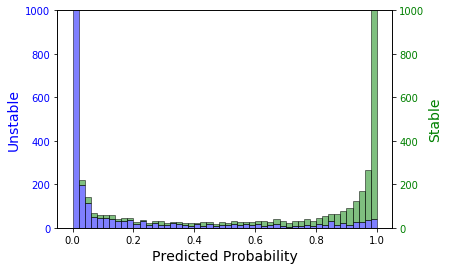

In [107]:
# Histogram:

bins = 50
pred_prob= best_model.predict_proba(testX)[:,1]
Stable=pred_prob[np.where(testY==1)]
print Stable[:5][:]
Unstable=pred_prob[np.where(testY==0)]
print Stable.size, Unstable.size

fig, ax1 = plt.subplots()
ax1.hist([Unstable, Stable], bins, alpha=0.5, label='No', color=['blue', 'green'], linewidth = 1, edgecolor='black', histtype='barstacked')
#ax1.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
print Stable.size
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    

ax2 = ax1.twinx()
#ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', linewidth = 1, edgecolor='black', histtype='barstacked')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
 
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1000]) # goes up to ~4300
ax2.set_ylim([0,1000]) # goes up to ~2100

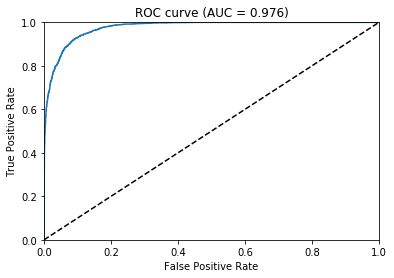

In [110]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, pred_prob)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, pred_prob)))

In [111]:
for i in range(0,len(fpr), 10):
    print("Threshold {0}, FPR = {1}, TPR = {2}".format(thresholds[i], fpr[i], tpr[i]))

Threshold 0.999977588654, FPR = 0.0, TPR = 0.000283205890683
Threshold 0.99994134903, FPR = 0.0, TPR = 0.0158595298782
Threshold 0.999923110008, FPR = 0.0, TPR = 0.0271877655055
Threshold 0.999889612198, FPR = 0.0, TPR = 0.0498442367601
Threshold 0.999871969223, FPR = 0.000182848784056, TPR = 0.0611724723874
Threshold 0.999843478203, FPR = 0.000182848784056, TPR = 0.0792976493911
Threshold 0.999823272228, FPR = 0.000182848784056, TPR = 0.0917587085811
Threshold 0.999798953533, FPR = 0.000182848784056, TPR = 0.102803738318
Threshold 0.999768078327, FPR = 0.000182848784056, TPR = 0.11611441518
Threshold 0.999719560146, FPR = 0.000182848784056, TPR = 0.133956386293
Threshold 0.999679803848, FPR = 0.000182848784056, TPR = 0.151231945624
Threshold 0.999615192413, FPR = 0.000182848784056, TPR = 0.171905975644
Threshold 0.999540925026, FPR = 0.000182848784056, TPR = 0.193712829227
Threshold 0.999253094196, FPR = 0.000182848784056, TPR = 0.24893797791
Threshold 0.999185025692, FPR = 0.00018284

AUC Score (Test): 0.962779


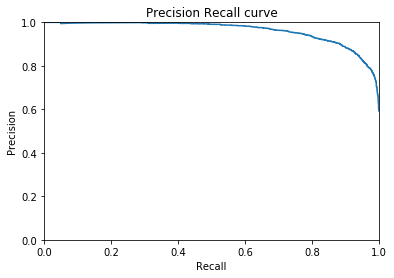

In [112]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, pred_prob)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')
print "AUC Score (Test): %f" % metrics.average_precision_score(testY, pred_prob)

This is re-running the model on a grid search centered aroun doptimal values found from Dan's notebook

In [ ]:
#reduce number of n_estimators because 5000 will forsure take too long
model3 = XGBClassifier(seed = 3, n_estimators=1000, colsample_bytree=1)
max_depth = [6,7,8,9]
learning_rate = np.linspace(0.001,0.007, 4)
min_c_w = np.linspace(0, 0.5, 5)
subsample = np.linspace(0.5, 1, 6)
param_grid = dict(learning_rate= learning_rate, max_depth = max_depth, min_child_weight = min_c_w, subsample = subsample)
grid = GridSearchCV(estimator = model3, param_grid = param_grid, scoring='average_precision',iid=False,cv=5, verbose = 85, n_jobs=4)
grid.fit(X, y) #total dataset

# get the names of the parameters
param_names = param_grid.keys()
param_vals = [[val for val in param_grid[param_name]] for param_name in param_names]
param_val_names = {param_name:["{0}".format(val) for val in param_grid[param_name]] for param_name in param_names}

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to new file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickl

[CV]  subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.0, score=0.960040 -  28.4s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   56.9s
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.0, score=0.958439 -  28.4s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   57.7s
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.0, score=0.957188 -  29.5s
[CV] subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:  2.3min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.0, score=0.958557 -  30.9s
[CV] subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:  2.5min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.5, learning_rate=0.001, max_depth=6, min_child_weight=0.125, score=0.964697 -  25.2s
[CV] subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:  3.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=6, min_child_weight=0.125, score=0.960143 -  24.2s
[CV] subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:  3.8min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done  41 tasks      | elapsed:  5.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.125, score=0.957852 -  27.6s
[CV] subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.125, score=0.956888 -  29.7s
[CV] subsample=0.5, learning_rate=0.001, max_depth=6, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.6min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.125, score=0.958626 -  30.8s
[CV] subsample=0.5, learning_rate=0.001, max_depth=6, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:  6.7min
Pickling array (shape=(30,), d

[CV]  subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.25, score=0.964481 -  27.8s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed:  8.0min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.25, score=0.958448 -  24.5s
[CV]  subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.25, score=0.960003 -  27.4s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weig

[CV]  subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.25, score=0.957228 -  30.3s
[CV] subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  9.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.25, score=0.959684 -  29.3s
[CV] subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:  9.5min
Pickling array (shape=(30,), dty

[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed: 10.6min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=6, min_child_weight=0.375, score=0.964682 -  23.6s
[CV] subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done  89 tasks      | elapsed: 10.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.375, score=0.964267 -  26.8s
[CV] subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed: 11.9min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.375, score=0.959595 -  26.7s
[CV] subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 101 tasks      | elapsed: 12.2min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done 111 tasks      | elapsed: 13.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.375, score=0.955554 -  30.6s
[CV] subsample=1.0, learning_rate=0.001, max_depth=6, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 112 tasks      | elapsed: 13.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.5, score=0.960771 -  26.0s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed: 14.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=6, min_child_weight=0.5, score=0.959843 -  25.3s
[CV] subsample=0.7, learning_rate=0.001, max_depth=6, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 124 tasks      | elapsed: 14.8min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.5, score=0.959126 -  27.6s
[CV] subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 135 tasks      | elapsed: 16.2min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=6, min_child_weight=0.5, score=0.963907 -  29.5s
[CV] subsample=0.9, learning_rate=0.001, max_depth=6, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed: 16.2min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.961855 -  32.3s
[CV] subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 147 tasks      | elapsed: 17.7min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.962493 -  35.4s
[CV] subsample=0.6, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 148 tasks      | elapsed: 17.8min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.961183 -  33.8s
[CV] subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 159 tasks      | elapsed: 19.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.965303 -  36.3s
[CV] subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 160 tasks      | elapsed: 19.5min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.960147 -  35.5s
[CV] subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 171 tasks      | elapsed: 21.2min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.0, score=0.956821 -  40.2s
[CV] subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed: 21.5min
Pickling array (shape=(30,), dtype=o

[Parallel(n_jobs=4)]: Done 182 tasks      | elapsed: 22.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=7, min_child_weight=0.125, score=0.962502 -  33.5s
[CV] subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 183 tasks      | elapsed: 23.0min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.125, score=0.960951 -  35.5s
[CV] subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 194 tasks      | elapsed: 24.5min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.125, score=0.965059 -  37.0s
[CV] subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 195 tasks      | elapsed: 24.8min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done 205 tasks      | elapsed: 26.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.125, score=0.958794 -  36.0s
[CV] subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 206 tasks      | elapsed: 26.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-1400

[CV]  subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.25, score=0.960803 -  34.4s
[CV] subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 217 tasks      | elapsed: 28.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.25, score=0.962213 -  36.2s
[CV] subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 218 tasks      | elapsed: 28.1min
Pickling array (shape=(30,), dty

[CV]  subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.25, score=0.960116 -  36.2s
[CV] subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 229 tasks      | elapsed: 29.9min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.25, score=0.964328 -  34.8s
[CV] subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 230 tasks      | elapsed: 29.9min
Pickling array (shape=(30,), dty

[Parallel(n_jobs=4)]: Done 240 tasks      | elapsed: 31.3min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.375, score=0.961277 -  30.3s
[CV] subsample=0.6, learning_rate=0.001, max_depth=7, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 241 tasks      | elapsed: 31.6min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.375, score=0.960326 -  34.7s
[CV] subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 252 tasks      | elapsed: 33.0min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=7, min_child_weight=0.375, score=0.962078 -  37.2s
[CV] subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 253 tasks      | elapsed: 33.3min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done 263 tasks      | elapsed: 34.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.375, score=0.958343 -  37.6s
[CV] subsample=0.5, learning_rate=0.001, max_depth=7, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed: 34.9min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-14006

[CV]  subsample=0.6, learning_rate=0.001, max_depth=7, min_child_weight=0.5, score=0.965346 -  33.3s
[CV] subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 275 tasks      | elapsed: 36.5min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=7, min_child_weight=0.5, score=0.961224 -  33.7s
[CV] subsample=0.7, learning_rate=0.001, max_depth=7, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 276 tasks      | elapsed: 36.6min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.5, score=0.959765 -  52.5s
[CV] subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 287 tasks      | elapsed: 38.5min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=7, min_child_weight=0.5, score=0.961508 -  49.5s
[CV] subsample=1.0, learning_rate=0.001, max_depth=7, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 288 tasks      | elapsed: 38.6min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.962277 -  40.5s
[CV] subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 299 tasks      | elapsed: 40.4min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.965975 -  40.7s
[CV] subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed: 40.6min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.961613 -  42.3s
[CV] subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 311 tasks      | elapsed: 42.7min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.961741 -  44.9s
[CV] subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed: 43.0min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.959830 -  48.8s
[CV] subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 323 tasks      | elapsed: 45.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.0, score=0.958079 -  50.2s
[CV] subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 324 tasks      | elapsed: 45.4min
Pickling array (shape=(30,), dty

[Parallel(n_jobs=4)]: Done 334 tasks      | elapsed: 47.5min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.125, score=0.965898 -  50.9s
[CV] subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 335 tasks      | elapsed: 47.5min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.125, score=0.961665 -  43.5s
[CV] subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 346 tasks      | elapsed: 49.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.125, score=0.961052 -  44.3s
[CV] subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 347 tasks      | elapsed: 49.8min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 52.2min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.962857 -  41.0s
[CV] subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[CV]  subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.962336 -  39.0s
[CV] subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 358 tasks      | elapsed: 52.4min
Pickling array (shape=(30,), dty

[CV]  subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.962013 -  46.8s
[CV] subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 369 tasks      | elapsed: 54.6min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.965742 -  44.1s
[CV] subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 370 tasks      | elapsed: 54.8min
Pickling array (shape=(30,), dty

[CV]  subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.961196 -  45.6s
[CV] subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[Parallel(n_jobs=4)]: Done 381 tasks      | elapsed: 56.9min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.957884 -  47.6s
[CV] subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.25 
[CV]  subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.25, score=0.959967 

[Parallel(n_jobs=4)]: Done 392 tasks      | elapsed: 58.8min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=8, min_child_weight=0.375, score=0.963067 -  39.4s
[CV] subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 393 tasks      | elapsed: 58.9min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140

[CV]  subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.375, score=0.961579 - 1.1min
[CV] subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 404 tasks      | elapsed: 61.3min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.375, score=0.965444 - 1.0min
[CV] subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.375 
[Parallel(n_jobs=4)]: Done 405 tasks      | elapsed: 61.3min
Pickling array (shape=(30,),

[Parallel(n_jobs=4)]: Done 415 tasks      | elapsed: 64.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.5, score=0.962924 -  45.1s
[CV] subsample=0.5, learning_rate=0.001, max_depth=8, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 416 tasks      | elapsed: 64.3min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-1400670

[CV]  subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.5, score=0.962128 -  40.1s
[CV] subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 427 tasks      | elapsed: 66.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(12000,), dtype=int64).
Pickling array (shape=(2999,), dtype=int64).
[CV]  subsample=0.7, learning_rate=0.001, max_depth=8, min_child_weight=0.5, score=0.962943 -  41.6s
[CV] subsample=0.8, learning_rate=0.001, max_depth=8, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 428 tasks      | elapsed: 66.3min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.5, score=0.960726 -  44.8s
[CV] subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 439 tasks      | elapsed: 68.3min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.9, learning_rate=0.001, max_depth=8, min_child_weight=0.5, score=0.964862 -  45.3s
[CV] subsample=1.0, learning_rate=0.001, max_depth=8, min_child_weight=0.5 
[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed: 68.5min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.5, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.962271 -  45.9s
[CV] subsample=0.6, learning_rate=0.001, max_depth=9, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 451 tasks      | elapsed: 70.6min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.6, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.963101 -  49.3s
[CV] subsample=0.6, learning_rate=0.001, max_depth=9, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 452 tasks      | elapsed: 70.8min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=0.8, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.962607 -  54.3s
[CV] subsample=0.9, learning_rate=0.001, max_depth=9, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 463 tasks      | elapsed: 73.2min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=0.8, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.961700 -  52.5s
[CV] subsample=0.9, learning_rate=0.001, max_depth=9, min_child_weight=0.0 
[Parallel(n_jobs=4)]: Done 464 tasks      | elapsed: 73.4min
Pickling array (shape=(30,), dtype=o

[CV]  subsample=1.0, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.962165 -  55.0s
[CV] subsample=0.5, learning_rate=0.001, max_depth=9, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 475 tasks      | elapsed: 76.1min
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=int64).
Memmaping (shape=(30, 14999), dtype=float64) to old file /dev/shm/joblib_memmaping_pool_18757_140067010086928/18757-140067016841680-d0bd192e76eba837a86396a16bf1c35c.pkl
Pickling array (shape=(30,), dtype=object).
Pickling array (shape=(14999,), dtype=float64).
Pickling array (shape=(14999,), dtype=int64).
Pickling array (shape=(11999,), dtype=int64).
Pickling array (shape=(3000,), dtype=int64).
[CV]  subsample=1.0, learning_rate=0.001, max_depth=9, min_child_weight=0.0, score=0.960263 -  55.6s
[CV] subsample=0.5, learning_rate=0.001, max_depth=9, min_child_weight=0.125 
[Parallel(n_jobs=4)]: Done 476 tasks      | elapsed: 76.2min
Pickling array (shape=(30,), dty